# Neural Network
***
**Name**: David Young-Jae Kim
***

## Goal

The goal of this assignment is to build a one-hidden-layer back propagation network to process real data.  For this assignment you will implement the neural net (activation function and training code) yourself, not using tensorflow or other deep learning frameworks. The purpose is for you to understand the nitty gritty of what these frameworks are doing for you before we switch over to using them.

## Data 
***

In this assignment you will be using the Occupancy Detection data set (ODD). It consists of experimental data used for binary classification of room occupancy (i.e., room is occupied versus empty) based on temperature, humidity, light, and CO2 sensors. The train and test data sets are each collected over a week period.

The data set includes time stamps with date and hour/minute/second within the day. You are **not to use time stamp features** for predicting occupancy. Since this is a commercial office building, the time stamp is a strong predictor of occupancy. Rather, the goal is to determine whether occupancy - **occ** can be sensed from:
1. temperature, expressed in degrees Celsius - **temp**
2. relative humidity, expressed as a % - **hum**
3. light, in lux - **light**
4. CO2, in ppm - **cdx**
5. humidity ratio, which is derived from the temperature and the relative humidity - **hum_ratio**

In [0]:
import numpy as np
import pandas as pd
import pickle
from sklearn.model_selection import train_test_split
from sklearn.utils import shuffle
from matplotlib import pyplot as plt

In [0]:
data = pd.read_csv('data/datatraining.txt')
X = data[['date', 'Humidity', 'Light', 'CO2', 'HumidityRatio', 'Temperature']].values
y = data['Occupancy'].values

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.1)

### 1. Perceptron
***

Using the perceptron code you wrote for Assignment 1, train a perceptron (linear activation function with a binary threshold) using the training set. Your perceptron should have the 5 input variables described above.

**Part A**: Report the training and test set performance in terms of % examples classified correctly after 100 epochs.

**NOTE**: The Perceptron Update Rule is guaranteed to converge only if there is a setting of the weights that will classify the training set perfectly.  (The learning rule minimizes mistakes. When all examples are classified correctly, the weights stop changing.)  With a noisy data set like this one, the algorithm may not terminate.  Also remember that the perceptron algorithm is performing stochastic gradient descent. Thus, it will jitter around the ideal solution continually changing the weights from one iteration to the next. The weight changes will have a small effect on performance, so you'll see training set performance jitter a bit as well.

In [0]:
def change_y_values(y):
    y_ = np.copy(y)
    for i in range(len(y_)):
        if y_[i] == 0:
            y_[i] = -1
    return y_

def perceptron_update(X, y, w, alpha):
    """
    One epoch of Perceptron updates (full sweep of the dataset).
    
    Parameters
    ----------
    X : NumPy array of features (size : no of examples X features)
    y : Numpy array of class labels (size : no of examples X 1)
    w : array of coefficients from the previous iteration
    
    Returns
    -------
    w : Coefficients of the classifier (after updating)
    incorrect : Incorrectly classified examples
    """
    y_ = change_y_values(y)
    incorrect = 0
    
    for i in range(len(y)):
        if y_[i] * np.dot(X[i],w) < 0:
            w = w + alpha*y_[i]*X[i]
            incorrect += 1
    
    return w,incorrect

def perceptron(X, y, maxIter, alpha):
    """
    Implements the Perceptron algorithm.
    
    Parameters
    ----------
    X : NumPy array of features (size : no of examples X features)
    y : Numpy array of class labels (size : no of examples X 1)
    maxIter : The maximum number of iterations allowed 
    alpha : Learning Rate
    
    Returns
    -------
    w : Coefficients of the classifier
    incorrect : Incorrectly classified examples on termination
    """
    incorrect_list=[]
    w = np.random.rand(len(X[0]))
    for i in range(maxIter):
        X, y = shuffle(X, y)
        w, incorrect = perceptron_update(X, y, w, alpha)
        incorrect_list.append(incorrect)
    return w,incorrect_list[-1]

w, n = perceptron(X_train.T[1:].T, y_train, 100, 0.001)

print(w)
print(n)

def classify(X, y, w):
    """
    Use this function to classify examples in the test set
    
    Parameters
    ----------
    X : Test set features
    y : Test set labels
    w : Perceptron coefficients
    
    Returns
    -------
    correct : number of correctly classified examples
    """
    correct = 0
    y_ = change_y_values(y) 
    for i in range(len(y)):
        if y_[i] * np.dot(X[i],w) > 0:
            correct += 1
    return correct

print(classify(X_test.T[1:].T,y_test,w)/len(y_test))

[-14.502511154077919 3.089206643316477 1.1723452439606552
 0.3054056585095855 -68.64948481017025]
221
0.9852760736196319


### 2. 1-layer feedforward neural net
***

In this part, you will implement a 1-layer feedforward neural network from scratch as shown in the figure below.
<img src="./res/mlp_ann.png" alt="mlp_ann" style="width:500px;"/>
Your tasks are as follows:

**PART 2.A**

1. Implement `sigmoid(x)`: In this assignment, we will be using the sigmoid activation function as the non-linearity.
2. Implement `forward(x)` which calculates the activations at layer 1, 2 and 3 (stored in variables `_a01`, `_a12`, `_a23` respectively) and returns the final layer activations.
3. Implement `backward(y, y_hat)` such that it returns layer 1 and layer 2 gradients using the mean squared loss between the predicted and groundtruth vectors.
4. Implement `update(l1_grad, l2_grad)` function which will update the weights and biases stored in `_W1, _W2 and _b1, _b2`.
5. Implement`train(X, y, epochs)`.
6. Implement `predict(X)` to return one-hot encoded representation of the `_a23` layer activation.

In [0]:

rndg = np.random.RandomState(seed=0)

class MLP(object):
    """
        -- Skeleton Code for a Multi-Layer Perceptron Neural Net.
           Network has 1 input layer followed by a hidden layer and
           an output layer. 
        
    """
    def __init__(self, n_vis=5, n_hid=10, n_out=1, batch_size=7, lr=0.1):
        """
            Initialize an MLP object.
            
            params
            
            n_vis (int): # of neurons in input layer.
            n_hid (int): # of neurons in hidden layer.
            n_out (int): # number of neurons in final output layer.
            batch_size (int): # number of X,y instances in a mini-batch.
            lr (double): learning rate/step size.

            class variables:
            
            _W1, _b1 (np.ndarray): 
                Weights and biases of the input layer respectively.
            
            _W2, _b2 (np.ndarray):
                Weights and biases of the hidden layer respectively.
            
            _a01, _a12, _a23 (np.ndarray or None):
                Activations from input, hidden and output layer respectively. 
                
            _l1_grad_b1, _l2_grad_b2 (np.ndarray or None):
                Gradients of the loss w.r.t. the biases. 
        """
        self._n_vis = n_vis
        self._n_hid = n_hid
        self._n_out = n_out
        
        self._W1 = rndg.normal(size=(self._n_hid, self._n_vis))
        self._b1 = np.ones((self._n_hid, 1))

        self._W2 = rndg.normal(size=(self._n_out, self._n_hid))
        self._b2 = np.ones((self._n_out, 1))

        self._a01 = None
        self._a12 = None
        self._a23 = None
        
        self._l1_grad_b1 = None
        self._l2_grad_b2 = None
        
        self.batch_size = batch_size
        self.lr = lr

    def sigmoid(self, X):
        """
            Sigmoid Logistic Function.
            
            params:
            
            X (np.ndarray)
            
            return:
            
            result (np.ndarray): result = f(X) 
                where f is the sigmoid function.
            
        """
        result = 1.0 / (1.0 + np.exp(-X.astype(float))) 
        return result
        #raise NotImplementedError()
        

    def forward(self, X):
        """
            Feed forward an input through each 
            of the layers of network.
            
            Store each layer activation in the class 
            variables defined in the constructor. You'll
            need them later during backpropogation.
            
            params:
            
            X (np.ndarray): batch_size x 5 dimensional array
            
            return:
            
            y_hat (np.ndarray): 1 x batch_size dimensional array
                representing final layer outputs.
            
        """
        self._a01 = X.T
        z = np.dot(self._W1, self._a01) + self._b1
        self._a12 = self.sigmoid(z)

        z = np.dot(self._W2, self._a12) + self._b2
        self._a23 = self.sigmoid(z)

        return self._a23
        #raise NotImplementedError()

    def backward(self, y, y_hat):
        
        """
            Implement the backpropogation algorithm.
            Assume mean squared loss at the output.
            calculate and update gradients of the loss w.r.t. the biases
            
            params:
            
            y (np.ndarray): batch_size x 1 dimensional vector
                of grounf truth labels.
            y_hat (np.nd_array): 1 x batch_size dimensional vector
                of predicted lables from forward().
            
            return:
            
            l1_grad (np.ndarray): n_hid x n_vis dimensional array
                representing gradients for hidden layer. (gradients of the loss w.r.t. the _W1)
                
            l2_grad (np.ndarray): 1 x n_hid dimensional array
                representing gradients for input layer. (gradients of the loss w.r.t. the _W2)
            
        """
        
        delta = (y_hat - y) * (y_hat* (1 - y_hat))

        l2_grad = np.dot(delta, self._a12.T)
        self._l2_grad_b2 = np.mean(delta, axis=1).reshape((self._n_out, 1))

        delta = np.dot(self._W2.T, delta) * (self._a12* (1 - self._a12))

        l1_grad = np.dot(delta, self._a01.T)
        self._l1_grad_b1 = np.mean(delta, axis=1).reshape((self._n_hid, 1))

        return l1_grad, l2_grad
        #raise NotImplementedError()
                
    def update(self, l1_grad, l2_grad):
        """
            Implement the update rule for network weights and biases.
            
            params:
            
            l1_grad (np.ndarray): gradients for input layer.
            l2_grad (np.ndarray): gradients for hidden layer.
            
            return:
            
            none.
        """
        # TO-DO
        self._W1 = self._W1 - self.lr * l1_grad
        self._b1 = self._b1 - self.lr * self._l1_grad_b1

        self._W2 = self._W2 - self.lr * l2_grad
        self._b2 = self._b2 - self.lr * self._l2_grad_b2
        #raise NotImplementedError()
        
    def predict(self, X, threshold = 0.5):
        """
            Returns one hot encoding of vector X using 0.5
            as the threshold.
            
            params:
            
            X (np.ndarray): predictions/activations of the output layer.
            
            return:
            
            y (np.ndarray): one hot encoding of output layer.
        """
        y_pred = self.forward(X)
        for i in range(len(X)):
            if y_pred[0][i] >= threshold:
                y_pred[0][i] = 1
            else:
                y_pred[0][i] = 0
        return y_pred[0]

        #raise NotImplementedError()
    
    def train(self, X, y, epochs):
        """
            Implement the train loop for n epochs.
            In each epoch do the following:
            1. Shuffle the dataset.
            2. create self.batch_size sized-mini-batches of the dataset.
            3. get network predictions using forward().
            4. calculate the gradients using backward().
            5. update the network weights using update().
            6. Repeat 1-5 until convergence.
            
            params:
            
            X (np.ndarray): N x 5 dimensional ndarray of inputs.
            y (np.ndarray): N x 1 dimensional array of true labels.
            epochs (int): # of epochs to train the network for. 
            
            return:
            
            none.
        """
        # TO-DO
        for i in range(epochs):
            X, y = shuffle(X, y)
            for j in range(0,len(y),self.batch_size):
                y_hat = self.forward(X[j:j+self.batch_size])
                l1_grad, l2_grad = self.backward(y[j:j+self.batch_size], y_hat)
                self.update(l1_grad, l2_grad)
        #raise NotImplementedError()
            
    def test(self, X_test, y_test):
        """
            Implement the test function which reports accuracy of 
            the model on the test set X_test against the true labels
            y_test.
            
            You may re-use the predict and accuracy functions defined above.
            
            params:
            
            X_test (np.ndarray): N x M dimensional array where M is the 
                number of attributes considered for training the model.
            y_test (np.ndarray): N x 1 dimensional array.
            
            return:
            
            accuracy (double): accuracy of the predicted labels against the 
                groundtruth labels.
        """
        y_hat = self.predict(X_test)
        return self.accuracy(y_test, y_hat)
        #raise NotImplementedError()
    
    @classmethod
    def accuracy(self, y, y_hat):
        len_ = y.flatten().shape[0]
        return np.sum(y.flatten() == y_hat.flatten())/len_

    

In [0]:
import unittest
from sklearn.datasets import make_classification

def load_params(path, model):
    
    params = pickle.load(open(path, 'rb'))
    for key in params:
        model.__dict__[key] = params[key]

class TestMLP(unittest.TestCase):
    def setUp(self):
        
        self.net = MLP()
        self.pre_trained_model = load_params("./res/mlp.pkl", self.net)
        self.X = np.load("./res/x.npy")
        self.y = np.load("./res/y.npy")
        self.p = np.load("./res/p.npy")
        self.sigX = np.asarray([-1, -2, -3, 0, 1, 2, 3])
    
    def test_forward(self):
        self.assertEqual(np.sum(self.net.forward(self.X[901:])), np.sum(self.p))
    
    def test_train(self):
        x, y = make_classification(
            n_samples=1000,
            n_features=5,
            n_redundant=0,
            random_state=rndg
        )
        net = MLP(5, 5, 1, 7, 0.01)
        net.train(self.X[:900], self.y[:900], 100)
        self.assertTrue(net.accuracy(net.predict(self.X[901:]), self.y[901:]) > 0.88)
    
    def test_sigmoid(self):
        self.assertEqual(
            np.sum(self.net.sigmoid(self.sigX)), 3.5
        )
        
suite = unittest.TestLoader().loadTestsFromTestCase(TestMLP)
unittest.TextTestRunner().run(suite)

...
----------------------------------------------------------------------
Ran 3 tests in 0.985s

OK


<unittest.runner.TextTestResult run=3 errors=0 failures=0>

**PART 2.B**

Report the baseline performance of the untrained MLP that you built in **PART 2.A** using the selected values. To calculate the baseline score, feed-forward entire test set through the test function. The test function will return a set of predictions. Calculate the accuracy of these predictions against ground truth training lables.  
Report:
1. accuracy

In [0]:
### Part 2.B
mlp = MLP()
baseline_score = mlp.test(X_test.T[1:].T, y_test)
print (baseline_score)

0.20368098159509201


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:71: RuntimeWarning: overflow encountered in exp


**PART 2.C**

Select a learning rate, batch size and train the network for 100 epochs. Plot a graph of network's accuracy on the test data as a function of epoch. On the same graph, plot a constant horizontal line of the baseline score that you reported in **PART 2.B**.  

Report:
1. learning rate
2. batch size

In [0]:
### Part 2.C
mlp = MLP(batch_size=10, lr=0.0005)
acc = []
epochs = [i+1 for i in range(100)]
for i in epochs:
    mlp.train(X_train.T[1:].T, y_train, i)
    acc.append(mlp.test(X_test.T[1:].T, y_test))
    print (i, acc[-1])

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:71: RuntimeWarning: overflow encountered in exp


1 0.9300613496932515
2 0.8957055214723927
3 0.905521472392638
4 0.9079754601226994
5 0.9153374233128835
6 0.9165644171779141
7 0.9165644171779141
8 0.9153374233128835
9 0.9165644171779141
10 0.9153374233128835
11 0.9153374233128835
12 0.9325153374233128
13 0.9300613496932515
14 0.9312883435582822
15 0.9300613496932515
16 0.9312883435582822
17 0.9349693251533743
18 0.9300613496932515
19 0.9312883435582822
20 0.9312883435582822
21 0.9361963190184049
22 0.9361963190184049
23 0.9276073619631902
24 0.9349693251533743
25 0.9288343558282208
26 0.9312883435582822
27 0.9374233128834356
28 0.9337423312883436
29 0.9374233128834356
30 0.9374233128834356
31 0.9361963190184049
32 0.9361963190184049
33 0.9361963190184049
34 0.9411042944785276
35 0.943558282208589
36 0.9705521472392638
37 0.9693251533742331
38 0.9165644171779141
39 0.9153374233128835
40 0.9300613496932515
41 0.9300613496932515
42 0.9276073619631902
43 0.9300613496932515
44 0.9300613496932515
45 0.9300613496932515
46 0.9300613496932515

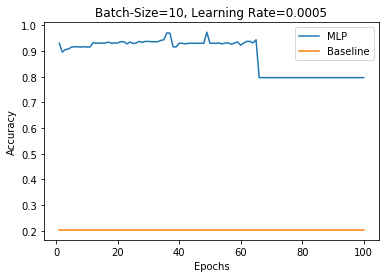

In [0]:
plt.plot(epochs, acc, label='MLP')
plt.plot(epochs, [baseline_score]*len(epochs), label='Baseline')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.title('Batch-Size=10, Learning Rate=0.0005')
plt.legend()
plt.show()

**PART 2.D**

Now train nets with varying size of the hidden layer $H={1, 2, 5, 10..}$ for max epochs = 100. Make a plot of the nets' accuracy on test set as a function of $H$.

In [0]:
### Part 2.D
H = [1, 2, 5, 10, 15, 20, 25, 35, 50]
acc_h = []
for h in H:
    mlp_h = MLP(n_hid=h, batch_size=10, lr=0.0005)
    mlp_h.train(X_train.T[1:].T, y_train, 100)
    acc_h.append(mlp_h.test(X_test.T[1:].T, y_test))
    print (h, acc_h[-1])

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:71: RuntimeWarning: overflow encountered in exp


1 0.7963190184049079
2 0.9312883435582822
5 0.9288343558282208
10 0.9288343558282208
15 0.9312883435582822
20 0.9276073619631902
25 0.9325153374233128
35 0.9288343558282208
50 0.9239263803680982


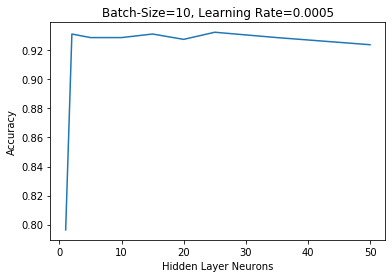

In [0]:
plt.plot(H, acc_h)
plt.xlabel('Hidden Layer Neurons')
plt.ylabel('Accuracy')
plt.title('Batch-Size=10, Learning Rate=0.0005')
plt.show()

### 3. Extra Credit

See how much adding information about time of day helps the network. Add a new set of inputs that represent the time of day. (Don't add information about day of week or absolute date.)  


**PART 3.A**  

Determine an appropriate representation for the time of day. Describe the representation you used. For example, you might add one unit with a value ranging from 0 to 1 for times ranging from 00:00 to 23:59. Report the representation you selected.


In [0]:
### Part 3.A
import datetime
import math

for i in range(len(X.T[0])):
    time = datetime.datetime.strptime(X.T[0][i].split()[1], '%H:%M:%S')
    X.T[0][i] = abs(time-datetime.datetime(1970,1,1)).total_seconds()

# Normalize the times using the minimum time
minm = np.amin(X.T[0])
X.T[0] = X.T[0] - minm
maxm = np.amax(X.T[0])
X.T[0] = X.T[0] / maxm

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.1)

**PART 3.B**  

Train your net with $H=5$ hidden and compare training and test set performance to the net you built in (2c)

In [0]:
### Part 3.B
mlp_time = MLP(n_vis=6, batch_size=10, lr=0.0005)
mlp_time.train(X_train, y_train, 100)
acc_time_test = mlp_time.test(X_test, y_test)
acc_time_train = mlp_time.test(X_test, y_test)
acc_train = mlp.test(X_train.T[1:].T, y_train)
acc_test = mlp.test(X_test.T[1:].T, y_test)

X = data[['date', 'Humidity', 'Light', 'CO2', 'HumidityRatio', 'Temperature']].values
y = data['Occupancy'].values

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:71: RuntimeWarning: overflow encountered in exp


In [0]:
print ("\nTRAIN ACCURACY\n")
print ("H=5, Features=5")
print (acc_train,"\n")
print ("H=5, Features=6")
print (acc_time_train,"\n")
print ("\nTEST ACCURACY\n")
print ("H=5, Features=5")
print (acc_test,"\n")
print ("H=5, Features=6")
print (acc_time_test,"\n")


TRAIN ACCURACY

H=5, Features=5
0.7876637554585153 

H=5, Features=6
0.9226993865030675 


TEST ACCURACY

H=5, Features=5
0.7840490797546013 

H=5, Features=6
0.9226993865030675 

